### This script is designed to train surrogate models for OpenFAST.
* The script reads the OpenFAST file and loads it into a dataframe
* Data is separated into training, validation and testing datasets
* Features are selected based on previous data analysis and context knowledge
* MLR model is trained on the training and tested on validation
* ANN model is trained on the training features. 
* Model hyperparameter refinement and learning protocols are defined using training/validation data
* results for both MLR and ANN are reported on the testing data (previously unused for all steps above)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import time

# packages for MLR
from sklearn import linear_model

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# packages we need for the Neural Net
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import model_from_json
from IPython.display import clear_output
from keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# choose the file location for the relevant OpenFAST run
filePath = './Umean_11_TI_0-151_Hs_1-8_Tp_9-1_TL_9000_w_controller.csv'
df_new = pd.read_csv(filePath, header=0)
df_new = df_new.astype(float)
df_new = df_new.set_index('Time')

In [3]:
df_new.head()

,Surge Vel,Heave Vel,Pitch Vel,Pitch Accel,Pitch,Windspeed,Thrust
Time,,,,,,,
0.000,0.000000,0.000000,0.000000,-0.1227,0.000000,12.42,2.386844e+06
0.025,-0.000016,-0.000018,-0.003086,-0.1523,-0.000038,12.39,2.000975e+06
0.050,-0.000350,-0.000270,-0.007558,-0.1564,-0.000169,12.36,1.946367e+06
0.075,-0.000428,-0.000420,-0.011200,-0.1630,-0.000405,12.33,1.823175e+06
0.100,-0.000651,-0.000641,-0.015510,-0.1638,-0.000737,12.30,1.680081e+06


In [4]:
windSpeed = df_new['Windspeed'].values
nacelleAcc = df_new['Pitch Accel'].values
pitchVel = df_new['Pitch Vel'].values
surgeVel = df_new['Surge Vel'].values
heaveVel = df_new['Heave Vel'].values
theta_5 = df_new['Pitch'].values

In [5]:
df_new['WS_MA_1_min'] = df_new['Windspeed'].rolling(window=40*60).mean()
df_new['WS_MA_10_sec'] = df_new['Windspeed'].rolling(window=400).mean()
df_new['WS_MA_1_sec'] = df_new['Windspeed'].rolling(window=40).mean()
# since we are using moving averages, the first minute of data is unavailable
maxLag = 60*40

Windspeed regimes are:
* Regime 1: U < 7
* Regime 2: 7 < U < 9.5
* Regime 3: 9.5 < U < 11
* Regime 4: U > 11

<br>
We are not interested in Regime 1

In [6]:
# define a feature that relates to the change in windspeed
df_new['delta WS'] = np.zeros((len(df_new)))
# lagged comparison to moving average
df_new['delta WS'] = df_new['WS_MA_1_sec'] - df_new['WS_MA_10_sec']

# add flags to windspeed change dependent on regime
# R2
test = df_new['delta WS'].values.copy()
test[np.where(df_new['WS_MA_1_sec']>9.5)[0]] = 0
df_new['delta WS R2'] = test
# R3
test = df_new['delta WS'].values.copy()
test[np.where(df_new['WS_MA_1_sec']<=9.5)[0]] = 0
test[np.where(df_new['WS_MA_1_sec']>11)[0]] = 0
df_new['delta WS R3'] = test
# R4
test = df_new['delta WS'].values.copy()
test[np.where(df_new['WS_MA_1_sec']<=11)[0]] = 0
df_new['delta WS R4'] = test

In [7]:
# thrust is always the target value for prediction
thrust = df_new['Thrust'].values

In [8]:
features = np.zeros((len(df_new)-maxLag,60*40+1+15))
# now there are features for 15 features defined in the cell below and 2401 previous timesteps

# difference in windspeed for different regimes
features[:,0] = df_new['delta WS R2'].values[maxLag:]
features[:,1] = df_new['delta WS R3'].values[maxLag:]
features[:,2] = df_new['delta WS R4'].values[maxLag:]

# average rel windspeed for last 1 min
features[:,3] = df_new['WS_MA_1_min'].values[maxLag:]
# average rel windspeed for last 10 sec
features[:,4] = df_new['WS_MA_10_sec'].values[maxLag:]
# average rel windspeed for last 1 sec
features[:,5] = df_new['WS_MA_1_sec'].values[maxLag:]
# nacelle acceleration (degs^-2)
features[:,6] = df_new['Pitch Accel'].values[maxLag:]
# nacelle velocity (degs^-1)
features[:,7] = pitchVel[maxLag:]
# heave velocity (ms^-1)
features[:,8] = heaveVel[maxLag:]
# surge velocity (ms^-1)
features[:,9] = surgeVel[maxLag:]
# pitch position (deg)
features[:,10] = theta_5[maxLag:]

# 1 sec moving average windspeed by regime
test = df_new['WS_MA_1_sec'].values[maxLag:].copy()
test[np.where(df_new['WS_MA_1_sec'].iloc[maxLag:]>9.5)[0]] = 0
features[:,11] = test
test = df_new['WS_MA_1_sec'].values[maxLag:].copy()
test[np.where(df_new['WS_MA_1_sec'].iloc[maxLag:]<=9.5)[0]]=0
test[np.where(df_new['WS_MA_1_sec'].iloc[maxLag:]>11)[0]] = 0
features[:,12] = test
test = df_new['WS_MA_1_sec'].values[maxLag:].copy()
test[np.where(df_new['WS_MA_1_sec'].iloc[maxLag:]<=11)[0]] = 0
features[:,13] = test

# 1 sec moving average windspeed
features[:,14] = df_new['delta WS'].values[maxLag:]

In [9]:
# add in the previous timesteps
for j in range(len(features)):
    features[j,15:] = windSpeed[j:j+1+maxLag]

The OpenFAST file used is 150 mins long
* first 90 minutes is allocated for training
* minutes 90-120 are allocated for validation
* minutes 120-150 are allocated for testing

In [10]:
# the sampling frequency is 40 Hz
startTrain = 0
startValidate = 90*60*40 - maxLag
startTest = 120*60*40 - maxLag
endTest = 150*60*40 - maxLag

# remember that the features is missing the first minute due to the 1 min moving average
yData = thrust[maxLag:endTest+maxLag]

# allocate the data for testing 
trainingFeatures = features[0:startValidate]
validateFeatures = features[startValidate:startTest]
testingFeatures = features[startTest:endTest]

yDataTrain = yData[0:startValidate]
yDataValidate = yData[startValidate:startTest]
yDataTest = yData[startTest:endTest]

In [11]:
# tidying up a little
del features
del yData

In [12]:
# # get parameters for scaling
# colMax = np.max(trainingFeatures,0);
# colMin = np.min(trainingFeatures,0);
# colRange = colMax-colMin;

# # save the scaling factor
# array = np.zeros((2416,2))
# array[:,0] = colMin
# array[:,1] = colRange
# # np.savetxt('scaling.csv', array, delimiter=',')

In [13]:
# # scale the data
# scaler = MinMaxScaler()
# trainingFeatures = scaler.fit_transform(trainingFeatures)
# validateFeatures = scaler.transform(validateFeatures)
# testingFeatures = scaler.transform(testingFeatures)

# the transform for the data is
# for j in range(len(trainingFeatures)):
#     trainingFeatures[j] = (trainingFeatures[j] - scalerMat[:,0])/scalerMat[:,1]

In [14]:
### MLR surrogate model

In [15]:
t = time.time()
MLR1 = linear_model.LinearRegression(fit_intercept=True)
# this first line initialises the model and specifies the options 
# we only use fit intercept and keep the rest default
MLR1.fit(trainingFeatures, yDataTrain)
# train the model
coefMLR1 = MLR1.coef_
deltaT = time.time()-t
print('elapsed time = %f'%deltaT)

elapsed time = 83.164811


In [16]:
# this is the predicted load
trainingMLR1 = MLR1.predict(trainingFeatures)
validateMLR1 = MLR1.predict(validateFeatures)

## Neural Net surrogate model

In [33]:
# create and fit Multilayer Perceptron model
NN1 = Sequential()
# first hidden layer, input_dim must equal the number of inputs
NN1.add(Dense(units=15, input_dim=np.shape(trainingFeatures)[1], activation='relu'))
# second hidden layer
NN1.add(Dense(units=15, activation='relu'))
# third hidden layer
NN1.add(Dense(units=15, activation='relu'))
# fourth hidden layer
NN1.add(Dense(units=15, activation='relu'))
# fifth hidden layer
NN1.add(Dense(units=15, activation='relu'))

# output layer
NN1.add(Dense(units=1))
NN1.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
class PlotLearning(callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs.plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)         
            axs.legend()
            axs.grid()

        plt.tight_layout()
        plt.show()
callbacks_list = [PlotLearning()]

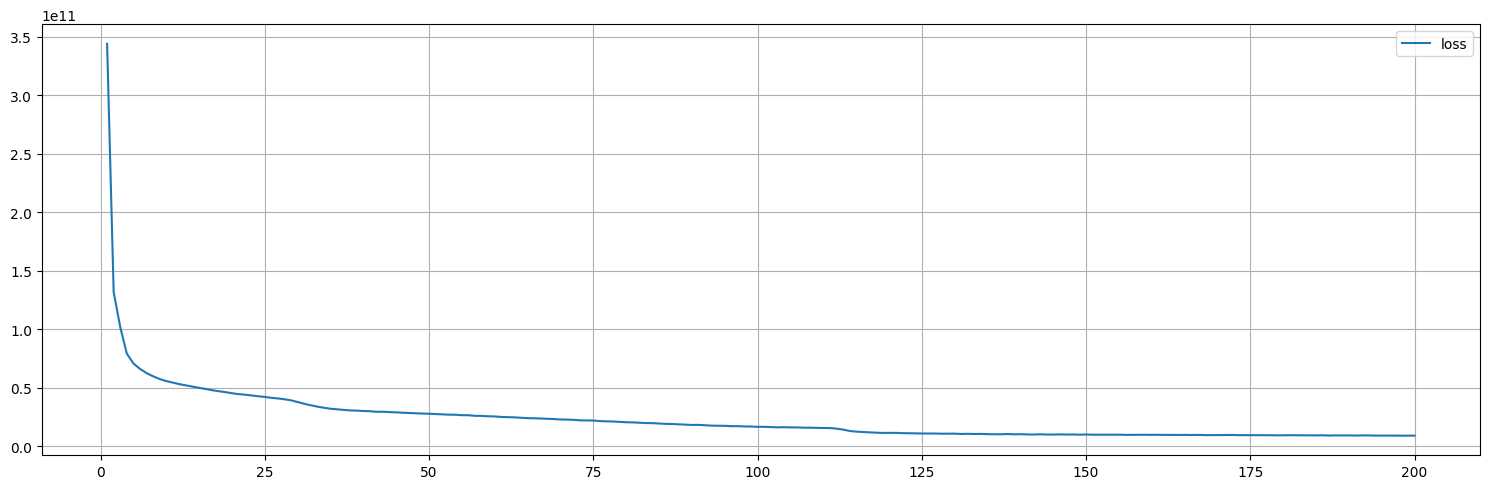

2136/2136 [==============================] - 2s 836us/step - loss: 9129783296.0000


In [35]:
history_1 = NN1.fit(trainingFeatures, yDataTrain, epochs=200, batch_size=100, verbose=1, callbacks=callbacks_list)

In [36]:
# fig = plt.figure(figsize=(5,2))
# ax1 = fig.add_subplot(121)
# ax1.plot(history_1.history['loss'])
# ax1.set_title('model loss')
# ax1.set_ylabel('loss')
# ax1.set_xlabel('epoch')
# plt.legend(['train'], loc='upper left')

In [37]:
# # create arrays with the predictions for the training and testing set
trainingNN1 = NN1.predict(trainingFeatures)
validateNN1 = NN1.predict(validateFeatures)
trainingNN1 = trainingNN1.flatten()
validateNN1 = validateNN1.flatten()

2250/2250 [==============================] - 1s 269us/step


### Error metrics

In [38]:
# MLR MAPEs
MLR1TrainMAPE = 100*np.mean( np.abs((trainingMLR1-yDataTrain)/yDataTrain) )
MLR1ValidateMAPE = 100*np.mean( np.abs((validateMLR1-yDataValidate)/yDataValidate) )
print('The training MAPE is %.2f'%MLR1TrainMAPE)
print('The validate MAPE is %.2f'%MLR1ValidateMAPE)

The training MAPE is 5.82
The validate MAPE is 5.88


In [39]:
meanthrust = np.mean(thrust[startTrain:startValidate])

In [40]:
MLR1TrainMAE = np.mean( np.abs((trainingMLR1-yDataTrain)) )
MLR1ValidateMAE = np.mean( np.abs((validateMLR1-yDataValidate)) )
print('The training MAE/ mean thrust is %.2f'%(100*MLR1TrainMAE/meanthrust))
print('The validate MAE/ mean thrust is %.2f'%(100*MLR1ValidateMAE/meanthrust))

The training MAE/ mean thrust is 5.39
The validate MAE/ mean thrust is 5.71


In [41]:
NN1TrainMAPE = 100*np.mean( np.abs((trainingNN1-yDataTrain)/yDataTrain) )
NN1ValidateMAPE = 100*np.mean( np.abs((validateNN1-yDataValidate)/yDataValidate) )
print('The training MAPE is %.2f'%NN1TrainMAPE)
print('The validate MAPE is %.2f'%NN1ValidateMAPE)

The training MAPE is 4.40
The validate MAPE is 4.44


In [42]:
NN1TrainMAE = np.mean( np.abs((trainingNN1-yDataTrain)) )
NN1ValidateMAE = np.mean( np.abs((validateNN1-yDataValidate)) )

print('The training MAE/ mean thrust is %.2f'%(100*NN1TrainMAE/meanthrust))
print('The validate MAE/ mean thrust is %.2f'%(100*NN1ValidateMAE/meanthrust))

The training MAE/ mean thrust is 4.16
The validate MAE/ mean thrust is 4.38


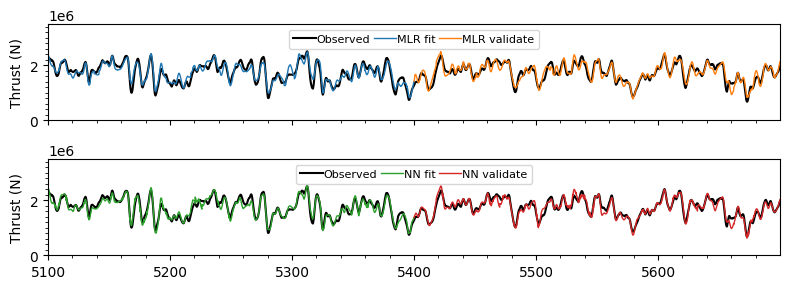

In [43]:
colors = sns.color_palette()

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(8,3)
ax1.plot(df_new['Thrust'].iloc[maxLag:maxLag+startTest], label='Observed', color='k', linestyle='-');
ax1.plot(df_new.index.to_numpy()[maxLag:maxLag+startValidate], trainingMLR1, label='MLR fit', linewidth=1, color=colors[0]);
ax1.plot(df_new.index.to_numpy()[maxLag+startValidate:maxLag+startTest], validateMLR1, label='MLR validate', linewidth=1, color=colors[1]);
ax1.set_ylabel('Thrust (N)');
ax1.set_ylim([0E6,3.5E6])
ax1.legend(fontsize=8, loc='upper center', ncol=3, handletextpad=0.1, columnspacing=0.3);
ax1.set_yticks(np.arange(0E6,3.5E6,2E5), minor=True);


ax2.plot(df_new['Thrust'].iloc[maxLag:maxLag+startTest], label='Observed', color='k', linestyle='-');
ax2.plot(df_new.index.to_numpy()[maxLag:maxLag+startValidate], trainingNN1, label='NN fit', linewidth=1, color=colors[2]);
ax2.plot(df_new.index.to_numpy()[maxLag+startValidate:maxLag+startTest], validateNN1, label='NN validate', linewidth=1, color=colors[3]);
# look at a portion of the training and validation
ax2.set_xlim([5100,5700]) 
ax2.set_ylabel('Thrust (N)');
ax2.set_ylim([0E6,3.5E6])
ax2.legend(fontsize=8, loc='upper center', ncol=3, handletextpad=0.1, columnspacing=0.3);
ax2.set_xticks(np.arange(5100,5700,100));
ax2.set_xticks(np.arange(5100,5700,20), minor=True);
ax2.set_yticks(np.arange(0E6,3.5E6,2E5), minor=True);
fig.tight_layout()

In [51]:
coefficient_of_determination = r2_score(yDataTrain, trainingMLR1)
print('R2 value for MLR train is %.3f'%coefficient_of_determination)
coefficient_of_determination = r2_score(yDataValidate, validateMLR1)
print('R2 value for MLR validate is %.3f'%coefficient_of_determination)
coefficient_of_determination = r2_score(yDataTrain, trainingNN1)
print('R2 value for NN train is %.3f'%coefficient_of_determination)
coefficient_of_determination = r2_score(yDataValidate, validateNN1)
print('R2 value for NN validate %.3f'%coefficient_of_determination)

R2 value for MLR train is 0.879
R2 value for MLR validate is 0.851
R2 value for NN train is 0.926
R2 value for NN validate 0.907


In [52]:
# # serialize model to JSON
# NN1_json = NN1.to_json()
# with open("NN1.json", "w") as json_file:
#     json_file.write(NN1_json)
# # serialize weights to HDF5
# NN1.save_weights("NN1_weights.h5")
# print("Saved model to disk")

In [53]:
Weights = NN1.get_weights()
Biases = [Weights[x] for x in [1,3,5,7,9,11]]
Weights = [Weights[x] for x in [0,2,4,6,8,10]]

In [54]:
# # save the biases:
# for j,b in enumerate(Biases):
#     fName = 'Layer_%d'%(j+1)+'_Biases.csv'
#     np.savetxt(fName, b, fmt='%.18e', delimiter=',')
    
# # save the weights:
# for j,W in enumerate(Weights):
#     fName = 'Layer_%d'%(j+1)+'_Weights.csv'
#     np.savetxt(fName, W, fmt='%.18e', delimiter=',')

# # Load the weights and biases
# Biases = []
# for j in range(6):
#     fName = 'Layer_%d'%(j+1)+'_Biases.csv'
#     b = np.genfromtxt(fName, delimiter=',')
#     Biases.append(b)
    
# Weights = []
# for j in range(6):
#     fName = 'Layer_%d'%(j+1)+'_Weights.csv'
#     W = np.genfromtxt(fName, delimiter=',')
#     Weights.append(W)

In [55]:
# rebuilding the NN with the weights and biases

def ReLU(u):
    u[u<0] = 0
    return u

def NN_thrust(data, Weights, Biases):
    # first layer
    u1 = np.matmul(Weights[0].T,data)+Biases[0].reshape(15,1)
    y1 = ReLU(u1)
    # second layer
    u2 = np.matmul(Weights[1].T,y1)+Biases[1].reshape(15,1)
    y2 = ReLU(u2)
    # third layer
    u3 = np.matmul(Weights[2].T,y2)+Biases[2].reshape(15,1)
    y3 = ReLU(u3)
    # fourth layer
    u4 = np.matmul(Weights[3].T,y3)+Biases[3].reshape(15,1)
    y4 = ReLU(u4)
    # fifth layer
    u5 = np.matmul(Weights[4].T,y4)+Biases[4].reshape(15,1)
    y5 = ReLU(u5)
    # output
    u6 = np.matmul(Weights[5].T,y5)+Biases[5]
    return u6

In [56]:
# verification we get the same results!

# trainingFeatures = (trainingFeatures - colMin)/colRange    
thrustNNFit = np.zeros((len(trainingFeatures)))
for j in range(len(trainingFeatures)):
    thrustNNFit[j] = NN_thrust(trainingFeatures[j].reshape(2416,1), Weights, Biases)[0][0]

# testingFeatures = (testingFeatures - colMin)/colRange    
thrustNNPredict = np.zeros((len(validateFeatures)))
for j in range(len(testingFeatures)):
    thrustNNPredict[j] = NN_thrust(validateFeatures[j].reshape(2416,1), Weights, Biases)[0][0]

NN1TrainMAE = np.mean( np.abs((thrustNNFit-yDataTrain)) )
NN1ValidateMAE = np.mean( np.abs((thrustNNPredict-yDataValidate)) )

print('The training MAE/ mean thrust is %.2f'%(100*NN1TrainMAE/meanthrust))
print('The testing MAE/ mean thrust is %.2f'%(100*NN1ValidateMAE/meanthrust))

The training MAE/ mean thrust is 4.16
The testing MAE/ mean thrust is 4.38
